In [1]:
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir
import numpy as np
import matplotlib.pyplot as plt
from reservoirpy.nodes import Reservoir, Ridge, FORCE, ESN
import pandas as pd 

import os

# 限制 OpenMP 只使用 2 个线程
os.environ["OMP_NUM_THREADS"] = "1"

rpy.verbosity(0)  # no need to be too verbose here
# rpy.set_seed(0)  # make everything reproducible!

0

In [2]:
dff=pd.read_csv("dff.csv",header=0,index_col=0)
dff1= pd.read_csv("Data_raw.csv",header=0,index_col=0)
dff["STR"] = dff1["STR"];

In [3]:
dff=dff.fillna(0)

In [4]:
test = dff.iloc[-245:]

In [5]:
L=245 # 需要训练245个Reservoir
Total = 816 #总共有816个数据
#For entire sample forecasting (1997.08-2017.12)
WL=Total-L # rolling window length 训练每一个Reservoir的数据集大小 WL=windows_length
ws=0# rolling window start index ws=277 for subsample, ws=0 for entire sample

In [6]:
RV=np.array(dff['RV']).reshape(-1,1)

In [7]:
F = ["RV", "MKT", "diff_DP", "IP", "DEF","EP","SMB","diff_TB","HML","INF","STR"]
features = len(F)

In [45]:
Data=np.array(dff[F]).reshape(-1,features)

In [ ]:
for N in [20,30,40,50,60,70,80,90,100]:
#     #rpy.set_seed(0)
    reservoir = Reservoir(N, input_dim=features, lr=0.6, sr=0.9, input_scaling=1)
#预测第t+1步的值，使用t-2,t-1,t步的数据
#因此 对于第一个预测任务，起始点是0,我们只能预测第3步的值。
    predictions_crl = np.zeros((L,1))
    ws=0
    K=3
    while ws < L:
        train_states = np.empty((WL-K, reservoir.output_dim)) #新建一个array 存储每一步的输出。
        for t in range(WL-K):#第0次迭代，输入t=0,1,2,预测3,第1次迭代，输入t=1,2,3,预测4，第WL-4次迭代（最后一次迭代），输入t=WL-4, WL-3, WL-2, 预测WL-1.
            X=np.array(Data[ws+t:ws+t+K,:]).reshape(-1,features)
            train_states[t,:] = reservoir.run(X, reset=True)[-1,:] #只取最后的输出。
        #完成训练数据收集
        #准备训练标签
        train_y = RV[ws+K:ws+WL]#
        readout = Ridge(ridge=1e-7)
        #训练读出层
        readout = readout.fit(train_states, train_y)#, warmup=0)
        
        #利用训练好的readout,预测第WL+1个数据,输入t=WL-3,WL-2,WL-1,预测WL
        X_test = np.array(Data[ws+WL-K:ws+WL]).reshape(-1,features)
        Y_test_states = reservoir.run(X_test,reset=True)[-1,:]
        predictions_crl[ws,0] = readout.run(Y_test_states)
        
        ws+=1 #起始点加一

    mse = np.mean((predictions_crl - RV[WL:]) ** 2)
    print("Hiden_size{},mse{}".format(N,mse))

Hiden_size20,mse0.20243537722869107
Hiden_size30,mse0.44945810789535895
Hiden_size40,mse0.2769367630438697
Hiden_size50,mse0.28272113082708883
Hiden_size60,mse0.25078364557321187
Hiden_size70,mse0.3216642123408612
Hiden_size80,mse0.27344999361759065
Hiden_size90,mse0.25554551976541734
Hiden_size100,mse0.3213269489532653


In [10]:
#设置读出函数
# readout = Ridge(ridge=1e-7)
# Y_train=np.array(RV[1:WL+1]).reshape(-1,1)
# readout = readout.fit(train_states, Y_train, warmup=3)

In [11]:
# states = np.empty((len(X), reservoir.output_dim))
# for i in range(len(X)):
#     states[i] = reservoir(X[i].reshape(1, -1))

In [12]:
#states = reservoir.run(X)

In [13]:
#重置状态
#reservoir = reservoir.reset()

In [14]:
#运行重置状态
#states_from_null1 = reservoir.run(X[0,:], reset=True)

In [15]:
#设置随机的初始状态
#a_state_vector = np.random.uniform(-1, 1, size=(1, reservoir.output_dim))
#states_from_a_starting_state = reservoir.run(Data, from_state=a_state_vector)

In [16]:
#previous_states = reservoir.run(X)

#reset 启动 
#with reservoir.with_state(reset=True):
    #states_from_null = reservoir.run(X)

# as if the with_state never happened!
#states_from_previous = reservoir.run(X)

In [17]:
# train_states = reservoir.run(X_train, reset=True)

In [18]:
#X_train 是[time_step=3,feature=1 或者 7]
#states = np.empty((len(X), reservoir.output_dim))
# for i in range(len(X)):
#     states[i] = reservoir.run(X_train,reset=True)[-1,:] 只需要最后一组state

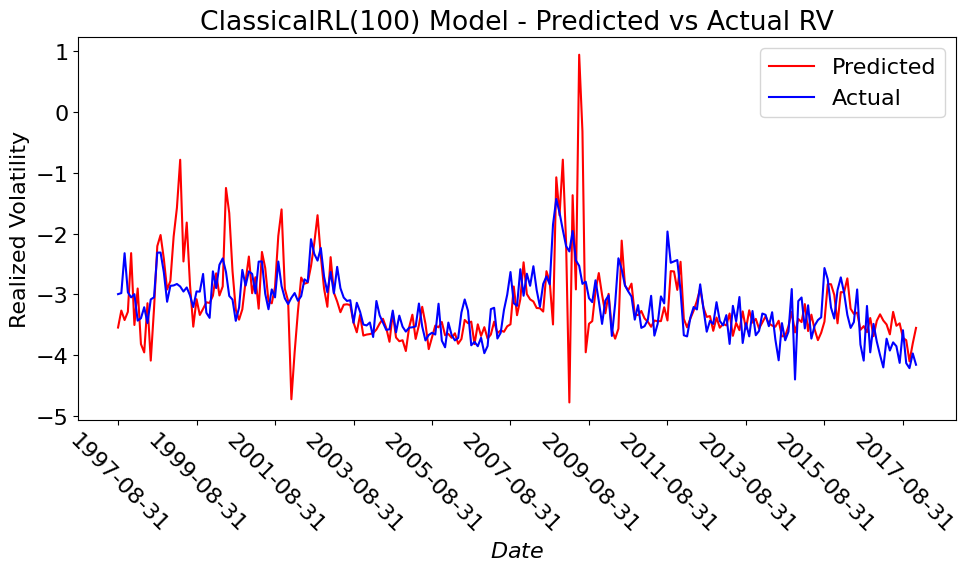

In [19]:
plt.figure(figsize=(10, 6))
plt.rcParams['font.size'] = 16
plt.title("ClassicalRL({}) Model - Predicted vs Actual RV".format(N))
plt.xlabel("$Date$")
plt.plot(test.index,predictions_crl, label="Predicted", color="red")
plt.plot(test.index,RV[WL:], label="Actual", color="blue")
plt.xticks(test.index[::24],rotation=-45)
plt.ylabel('Realized Volatility')
plt.tight_layout() 
plt.legend()
#plt.savefig("Classical_Reservoir_learning/CRL_model({}).png".format(N))
plt.show()

In [20]:
def compute_qlike(forecasts, actuals):
    """
    Compute the QLIKE (Quasi-Likelihood) loss function for evaluating forecasting accuracy.
    forecasts: Forecasted variance (sigma squared from a model)
    actuals: Realized variance (actual observed variance)
    """
    # Using absolute values of forecasts and actuals
    forecasts = np.abs(forecasts)
    actuals = np.abs(actuals)

    # Calculate the ratio and ensure it's positive
    ratio = actuals / forecasts

    # Compute QLIKE
    qlike = np.sum(ratio - np.log(ratio) - 1)
    return qlike


def qlike_loss(y_true, y_hat):
  """
  This function computes the mean Quasi-Likelihood (QLIKE) loss function.

  Args:
      y_true (np.ndarray): True values of the variable.
      y_hat (np.ndarray): Predicted values of the variable.

  Returns:
      float: Mean QLIKE loss between the true and predicted values.
  """
  eps = np.finfo(float).eps  # Machine epsilon for numerical stability
  w = np.abs(y_true - y_hat) / (y_hat + eps)
  return np.mean(np.log(1 + w**2))

In [21]:
actual = RV[WL:]

In [22]:
qlike_loss_value = qlike_loss(np.array(actual), np.array(predictions_crl))
print(qlike_loss_value)

qlike_loss = compute_qlike(np.array(predictions_crl), np.array(actual))
print(f"QLIKE Loss: {qlike_loss}")

0.06870916840628336
QLIKE Loss: 11.809465781511793


In [23]:
mse = np.mean((predictions_crl - RV[WL:]) ** 2)
print(mse)

0.3213269489532653


In [24]:
#np.savetxt("Classical_Reservoir_learning/best_CRLX({})_predictions.csv".format(N),predictions_crl,delimiter=',')

In [25]:
# forecasts = np.abs(predictions_crl)
# actuals = np.abs(actual)

# # Calculate the ratio and ensure it's positive
# ratio = actuals / forecasts

# # Compute QLIKE
# qlikes= ratio - np.log(ratio) - 1

In [26]:
#np.savetxt("Classical_Reservoir_learning/best_CRLX({})_qlike.csv".format(N),qlikes,delimiter=',')